# Maxcut example

## Setup

In [24]:
# General imports
import numpy as np

# Qiskit ansatz circuits
from qiskit.circuit.library import TwoLocal

# Qiskit primitives
from qiskit.primitives import Estimator as QiskitEstimator
from qiskit.primitives import Sampler as QiskitSampler

# Qiskit runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Estimator, Sampler, Session

# Qiskit optimization
from optimization import QuadraticProgram
from optimization.workflows import QUBO_transformer
from optimization.passes import (QUBO2Ising,
                                 EvaluateProgramSolution,
                                 UnrollQUBOVariables)

# Docplex
from docplex.mp.model import Model

# SPSA
from optimization.spsa import minimize_spsa

## Load the Runtime (if using)

In [8]:
#service = QiskitRuntimeService()

In [9]:
#backend = service.get_backend('ibm_nazca')

## Step 1: Build optimization problem using docplex and convert to QUBO
Define problem using standard classical representation.

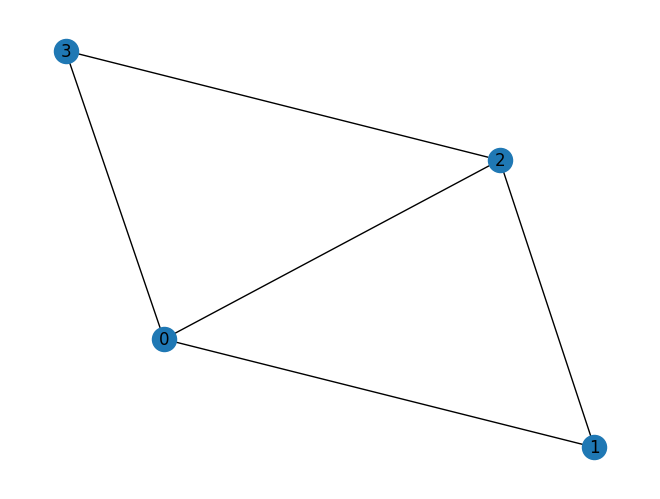

In [10]:
import rustworkx as rs
from rustworkx.visualization import mpl_draw

A = np.array([[0, 1, 1, 1],
              [1, 0, 1, 0],
              [1, 1, 0, 1],
              [1, 0, 1, 0]], dtype=float)

G = rs.PyGraph.from_adjacency_matrix(A)
mpl_draw(G, with_labels=True)

In [11]:
mdl = Model(name="Max-cut")
x = {i: mdl.binary_var(name=f"x_{i}") for i in range(G.num_nodes())}
objective = mdl.sum(w * x[i] * (1 - x[j]) + w * x[j] * (1 - x[i]) for i, j, w in G.weighted_edge_list())
mdl.maximize(objective)

### Convert to our `QuadraticProgram` format

In [12]:
qp = QuadraticProgram.from_docplex_mp(mdl)
qp

<QuadraticProgram: maximize -2*x_0*x_1 - 2*x_0*x_2 - 2*x_0*x_3 - 2*x_1*x_2 - 2..., 4 variables, 0 constraints, 'Max-cut'>

### Perform transformations to QUBO and return new program

In [14]:
qubo_transformer = QUBO_transformer()
qubo = qubo_transformer.run(qp)

## Step 2) Quantum native description
### Convert from QUBO to Ising

In [15]:
hamiltonian = QUBO2Ising().run(qubo)
hamiltonian

SparsePauliOp(['IIZZ', 'IZIZ', 'ZIIZ', 'IZZI', 'ZZII', 'IIII'],
              coeffs=[ 0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j, -2.5+0.j])

### Select ansatz circuit from circuit library

In [16]:
ansatz = TwoLocal(hamiltonian.num_qubits, 'ry', 'cx', 'linear', reps=2)

## Step 3: Solve using quantum accelerator
### Standard cost function definition

In [17]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return cost

### Setup estimator and sampler instances

In [18]:
#session = Session(backend=backend)
#estimator = Estimator(session=session, options={"shots": int(1e4)})
#sampler = Sampler(session=session, options={"shots": int(1e4)})
estimator = QiskitEstimator(options={"shots": int(1e4)})
sampler = QiskitSampler(options={"shots": int(1e4)})

### Perform minimization

In [19]:
x0 = 2*np.pi*np.random.random(size=ansatz.num_parameters)
res = minimize_spsa(cost_func, x0, args=(ansatz, hamiltonian, estimator), maxiter=100)

### Computute distribution at found minimum

In [21]:
# Assign solution parameters to ansatz
qc = ansatz.assign_parameters(res.x)
qc.measure_all()
samp_dist = sampler.run(qc, shots=int(1e4)).result().quasi_dists[0]
# Close the session since we are now done with it
#session.close()

### Express quantum solution as QUBO variable values
Convert bit-string solutions to variable values in QUBO problem

In [22]:
res = EvaluateProgramSolution(qubo).run(samp_dist)
res

(-4.0, array([1, 0, 1, 0]))

## Step 4: Classical postprocess
Unrolling QUBO variables back to the original problem definition.

In [23]:
solution = UnrollQUBOVariables(qubo_transformer).run(res)
solution

array([1., 0., 1., 0.])

## Intepretation of solution
Depends on input, but is completely separate from quantum having done the processing for the solution.